In [1]:
import os 
import glob
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.MSI.run_meta.organized.tsv', sep='\t')
dict_HRRid_to_metadata = { tup.Accession : [tup.SampleID, tup.PatientID, tup.TreatmentStage, tup.BiopsySite, tup.TMB, tup.Response ] for tup in df_metadata.itertuples() }

## Prepare analysis

### Check processed/unprocessed samples

In [4]:
df_metadata_PR = df_metadata[   (df_metadata['Response'].isin(['CR', 'PR'])) & 
                                (df_metadata['BiopsySite'].isin(['Adjacent normal tissue', 'Tumor'])) & 
                                (df_metadata['LibraryType']=='scRNA-seq')
                            ].copy()

DIR_cellranger_tumor_out    = '/node200data/18parkky/datasets/data/public/BAM/Immunotherapy_CRC_Chen_et_al/MSI/Tumor'
DIR_cellranger_normal_out   = '/node200data/18parkky/datasets/data/public/BAM/Immunotherapy_CRC_Chen_et_al/MSI/Adjacent_normal_tissue'

processed_samples_summary = list()

for tup in df_metadata_PR.itertuples():
    HRRid = tup.Accession
    if tup.BiopsySite == 'Tumor':
        DIR_cellranger_out_t = DIR_cellranger_tumor_out
    elif tup.BiopsySite == 'Adjacent normal tissue':
        DIR_cellranger_out_t = DIR_cellranger_normal_out
    else:
        raise ValueError
    
    temp_entry = [HRRid]
    if os.path.exists( f'{DIR_cellranger_out_t}/{HRRid}/outs' ) == True:
        bool_cellranger_processed = True
        # Check scrublet
        if os.path.exists(f'{DIR_cellranger_out_t}/{HRRid}/outs/filtered_feature_bc_matrix.scrublet.h5') == True:
            bool_scrublet_processed = True 
        else:
            bool_scrublet_processed = False
        # Check NanoMnT
        if os.path.exists( f'{DIR_cellranger_out_t}/{HRRid}/outs/possorted_genome_bam.STR_allele_table.tsv' ) == True:
            bool_NanoMnT_processed = True
        else: 
            bool_NanoMnT_processed = False 
    else:
        bool_cellranger_processed = False
        bool_scrublet_processed = False
        bool_NanoMnT_processed = False
    
    for md in  dict_HRRid_to_metadata[HRRid]:
        temp_entry.append(md)
        
    temp_entry.append( bool_cellranger_processed )
    temp_entry.append( bool_scrublet_processed )
    temp_entry.append( bool_NanoMnT_processed )
    
    processed_samples_summary.append( temp_entry )

processed_samples_summary = pd.DataFrame(processed_samples_summary)
processed_samples_summary.columns = ['HRRid', 'SampleID', 'PatientID', 'TreatmentStage', 'BiopsySite', 'TMB', 'Response', 'cellranger', 'scrublet', 'nanomnt']

In [7]:
processed_samples_summary[(processed_samples_summary['nanomnt']==True) & (processed_samples_summary['PatientID']=='P04')]

,HRRid,SampleID,PatientID,TreatmentStage,BiopsySite,TMB,Response,cellranger,scrublet,nanomnt
0,HRR1372976,P04-N-I,P04,Pre,Adjacent normal tissue,487,CR,True,True,True
1,HRR1372975,P04-N-I,P04,Pre,Adjacent normal tissue,487,CR,True,True,True
2,HRR1372974,P04-N-I,P04,Pre,Adjacent normal tissue,487,CR,True,True,True
3,HRR1372973,P04-N-I,P04,Pre,Adjacent normal tissue,487,CR,True,True,True
4,HRR1373024,P04-N-II,P04,On,Adjacent normal tissue,487,CR,True,True,True
5,HRR1373023,P04-N-II,P04,On,Adjacent normal tissue,487,CR,True,True,True
6,HRR1373022,P04-N-II,P04,On,Adjacent normal tissue,487,CR,True,True,True
7,HRR1373021,P04-N-II,P04,On,Adjacent normal tissue,487,CR,True,True,True
8,HRR1373072,P04-N-III,P04,Post,Adjacent normal tissue,487,CR,True,True,True
9,HRR1373071,P04-N-III,P04,Post,Adjacent normal tissue,487,CR,True,True,True


### Selectively run scrublet for un-processed samples

In [ ]:
for tup in processed_samples_summary[(processed_samples_summary['cellranger']==True) & (processed_samples_summary['scrublet']==False)]:
    
    if tup.BiopsySite == 'Tumor':
        DIR_cellranger_out_t = DIR_cellranger_tumor_out
    elif tup.BiopsySite == 'Adjacent normal tissue':
        DIR_cellranger_out_t = DIR_cellranger_normal_out
    else:
        raise ValueError
    
    adata_t = sc.read_10x_h5( f'{DIR_cellranger_out_t}/outs/filtered_feature_bc_matrix.h5' )    # Scrublet has yet to be done

    adata_t.obs['HRR_id']    = tup.HRRid
    adata_t.obs['SampleID']  = tup.SampleID
    adata_t.obs['PatientID'] = tup.PatientID
    adata_t.obs['TreatmentStage']  = tup.TreatmentStage
    adata_t.obs['BiopsySite']  = tup.BiopsySite
    adata_t.obs['TMB']  = tup.TMB
    adata_t.obs['Response']  = tup.Response
    
    adata_t.obs_names_make_unique()
    adata_t.var_names_make_unique()
    sc.pp.scrublet(adata_t)
    adata_t.write(f'{DIR_cellranger_out_t}/outs/filtered_feature_bc_matrix.scrublet.h5')
    
#! You might want to update processed_samples_summary after running this

## Start analysis (temp; processed files only)

In [10]:
processed_samples_summary_oi = processed_samples_summary[(processed_samples_summary['nanomnt']==True) & (processed_samples_summary['PatientID']=='P04')].copy()
processed_samples_summary_oi 

,HRRid,SampleID,PatientID,TreatmentStage,BiopsySite,TMB,Response,cellranger,scrublet,nanomnt
0,HRR1372976,P04-N-I,P04,Pre,Adjacent normal tissue,487,CR,True,True,True
1,HRR1372975,P04-N-I,P04,Pre,Adjacent normal tissue,487,CR,True,True,True
2,HRR1372974,P04-N-I,P04,Pre,Adjacent normal tissue,487,CR,True,True,True
3,HRR1372973,P04-N-I,P04,Pre,Adjacent normal tissue,487,CR,True,True,True
4,HRR1373024,P04-N-II,P04,On,Adjacent normal tissue,487,CR,True,True,True
5,HRR1373023,P04-N-II,P04,On,Adjacent normal tissue,487,CR,True,True,True
6,HRR1373022,P04-N-II,P04,On,Adjacent normal tissue,487,CR,True,True,True
7,HRR1373021,P04-N-II,P04,On,Adjacent normal tissue,487,CR,True,True,True
8,HRR1373072,P04-N-III,P04,Post,Adjacent normal tissue,487,CR,True,True,True
9,HRR1373071,P04-N-III,P04,Post,Adjacent normal tissue,487,CR,True,True,True


In [ ]:
list_adata = list()
list_alleleTable = list()

for tup in processed_samples_summary_oi.itertuples():
    if tup.BiopsySite == 'Tumor':
        DIR_cellranger_out_t = DIR_cellranger_tumor_out 
    elif tup.BiopsySite == 'Adjacent normal tissue':
        DIR_cellranger_out_t = DIR_cellranger_normal_out
    else:
        raise ValueError
    
    adata_t = sc.read_h5ad( f'{DIR_cellranger_out_t}/{tup.HRRid}/outs/filtered_feature_bc_matrix.scrublet.h5' )
    
    alleleTable = pd.read_csv( f'{DIR_cellranger_out_t}/{tup.HRRid}/outs/possorted_genome_bam.STR_allele_table.tsv', sep='\t' )
    alleleTable['HRRid'] = tup.HRRid
    alleleTable['PatientID'] = tup.PatientID
    alleleTable['TreatmentStage'] = tup.TreatmentStage
    alleleTable['BiopsySite'] = tup.BiopsySite
    alleleTable['Response'] = tup.Response

    list_adata.append( adata_t )
    list_alleleTable.append( alleleTable )

### Scanpy preprocessing

In [13]:
adata = sc.concat( list_adata  )
adata.var = list_adata[0].var
adata.obs_names_make_unique()

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [14]:
# adata.write('/node200data/18parkky/datasets/data/public/BAM/Immunotherapy_CRC_Chen_et_al/MSI/merged_adata.P04.h5')

In [15]:
print(adata.shape)
adata = adata[adata.obs['doublet_score']<=0.1]
print(adata.shape)
sc.pp.filter_cells(adata, min_genes=600)
sc.pp.filter_genes(adata, min_cells=10)
print(adata.shape)

adata.raw = adata
adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes=4000, batch_key="SampleID")
adata = adata[:, adata.var.highly_variable]

sc.tl.pca(adata, svd_solver="arpack")

sc.pp.neighbors(adata, n_pcs=20, use_rep='X_pca')
sc.tl.umap(adata)

for res in [0.02, 0.1, 0.2, 0.3, 0.5, 1.0]:
    # print(res)
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )

(202873, 36601)
(179300, 36601)


/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


(116304, 25671)


/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-14 15:42:26.083930: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 15:42:26.085405: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-14 15:42:26.090418: I external/local_xla/

In [16]:
df_iCMS_marker = pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/iCMS_marker/iCMS_marker_genes.csv')

iCMS2_up = list(df_iCMS_marker['iCMS2_Up'].dropna())
iCMS2_dw = list(df_iCMS_marker['iCMS2_Down'].dropna())
iCMS3_up = list(df_iCMS_marker['iCMS3_Up'].dropna())
iCMS3_dw = list(df_iCMS_marker['iCMS3_Down'].dropna())

sc.tl.score_genes(adata, iCMS3_up, score_name='iCMS3_up')
sc.tl.score_genes(adata, iCMS3_dw, score_name='iCMS3_dw')

### Overlay NanoMnT results

In [17]:
alleleTable = pd.concat(list_alleleTable)
alleleTable.reset_index(inplace=True, drop=True)

In [18]:
# filter out low-quality NanoMnT entries
alleleTable_f = list()
for tup in alleleTable.itertuples():
    if ("*" in tup.left_flanking_seq[-3:]) or ("*" in tup.right_flanking_seq[:3]) or (tup.left_flanking_seq[-1].upper() == tup.repeat_unit) or (tup.right_flanking_seq[0].upper() == tup.repeat_unit):
        continue
    else:
        alleleTable_f.append( tup )
        
alleleTable_f = pd.DataFrame(alleleTable_f)
alleleTable_f.drop('Index', axis=1, inplace=True)
alleleTable_f.dropna(inplace=True)

In [19]:
adata.obs['CB_wHRRid'] = [ f'{tup.Index}-{tup.HRR_id}' for tup in adata.obs.itertuples() ]
alleleTable_f['CB_wHRRid'] = [ f'{tup.CB}-{tup.HRRid}' for tup in alleleTable_f.itertuples() ]
alleleTable_f['diff'] = alleleTable_f['read_STR_length'] - alleleTable_f['reference_STR_allele']

In [20]:
dict_CBwHRRid_to_STRprofile = { CBwHRRid : [np.mean(edf['diff']), len(edf)] for CBwHRRid, edf in alleleTable_f.groupby("CB_wHRRid") }

In [21]:
for CBwHRRid in adata.obs['CB_wHRRid']:
    try: dict_CBwHRRid_to_STRprofile[CBwHRRid]
    except KeyError: dict_CBwHRRid_to_STRprofile[CBwHRRid] = [ -1, -1 ]

In [22]:
adata.obs['RawAvgSTR']  = [ dict_CBwHRRid_to_STRprofile[CBwHRRid][0] for CBwHRRid in adata.obs['CB_wHRRid']]
adata.obs['RawSTRn']    = [ dict_CBwHRRid_to_STRprofile[CBwHRRid][1] for CBwHRRid in adata.obs['CB_wHRRid']]

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


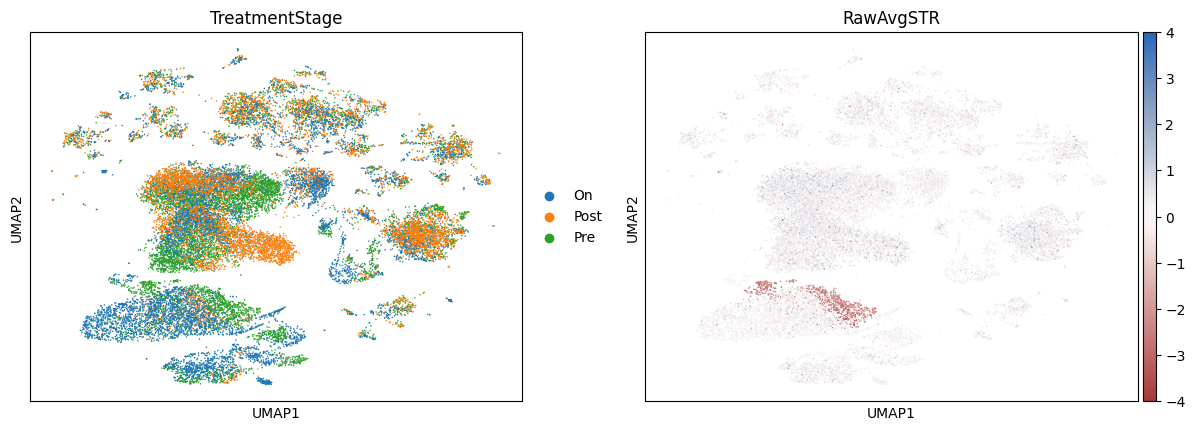

In [27]:
sc.pl.umap(adata[adata.obs['RawSTRn']>=10], color=['TreatmentStage', 'RawAvgSTR', ], cmap='vlag_r', ncols=2, vmin=-4, vmax=4)

In [ ]:
# adata.write('/node200data/18parkky/datasets/data/public/BAM/Immunotherapy_CRC_Chen_et_al/MSI/merged_adata.P04.h5')

### Overlay Author annotaion

In [29]:
author_adata_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/AuthorProcessedData/GSE236581_CRC-ICB_metadata.txt.gz', sep=' ')
author_adata_metadata['CRC_number'] = [ Ident.split("-")[0] for Ident in author_adata_metadata['Ident'] ]
dict_patientID_to_CRCnumber = { Patient : edf.iloc[0].CRC_number for Patient, edf in author_adata_metadata.groupby("Patient") }
dict_UniqueIdentifier_to_celltype = { tup.Index : [tup.MajorCellType, tup.SubCellType] for tup in author_adata_metadata.itertuples() }

adata.obs['Cell_UniqueIdentifier'] = [ f'{dict_patientID_to_CRCnumber[tup.PatientID]}-{"-".join(tup.SampleID.split("-")[1:])}_{tup.Index.split("-")[0]}' for tup in adata.obs.itertuples() ]
for CUI in adata.obs['Cell_UniqueIdentifier']:
    try: dict_UniqueIdentifier_to_celltype[CUI]
    except KeyError: dict_UniqueIdentifier_to_celltype[CUI] = [None, None]
adata.obs['MajorCellType']  = [ dict_UniqueIdentifier_to_celltype[CUI][0] for CUI in adata.obs['Cell_UniqueIdentifier'] ]
adata.obs['SubCellType']    = [ dict_UniqueIdentifier_to_celltype[CUI][1] for CUI in adata.obs['Cell_UniqueIdentifier'] ]

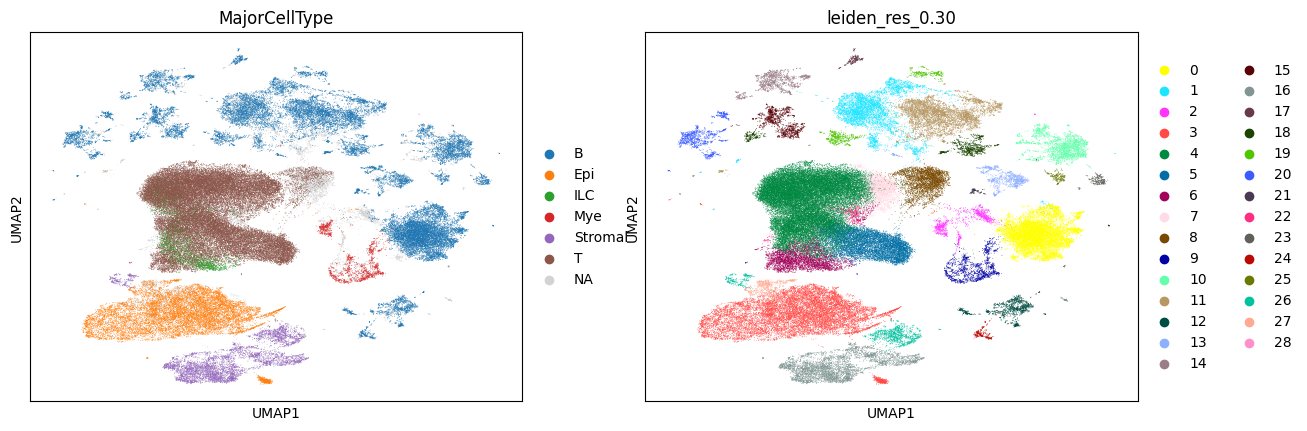

In [30]:
sc.pl.umap(adata, color=['MajorCellType', 'leiden_res_0.30',], )

In [32]:
adata_epi = adata[adata.obs['MajorCellType']=='Epi'].copy()
adata_epi = adata_epi.raw.to_adata()

In [33]:
adata_epi.raw = adata_epi
adata_epi.layers["counts"] = adata_epi.X.copy()

sc.pp.highly_variable_genes(adata_epi, n_top_genes=4000, batch_key="SampleID")
adata_epi = adata_epi[:, adata_epi.var.highly_variable]

sc.tl.pca(adata_epi, svd_solver="arpack")

sc.pp.neighbors(adata_epi, n_pcs=20, use_rep='X_pca')
sc.tl.umap(adata_epi)

for res in [0.02, 0.1, 0.2, 0.3, 0.5, 1.0]:
    sc.tl.leiden(
        adata_epi, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


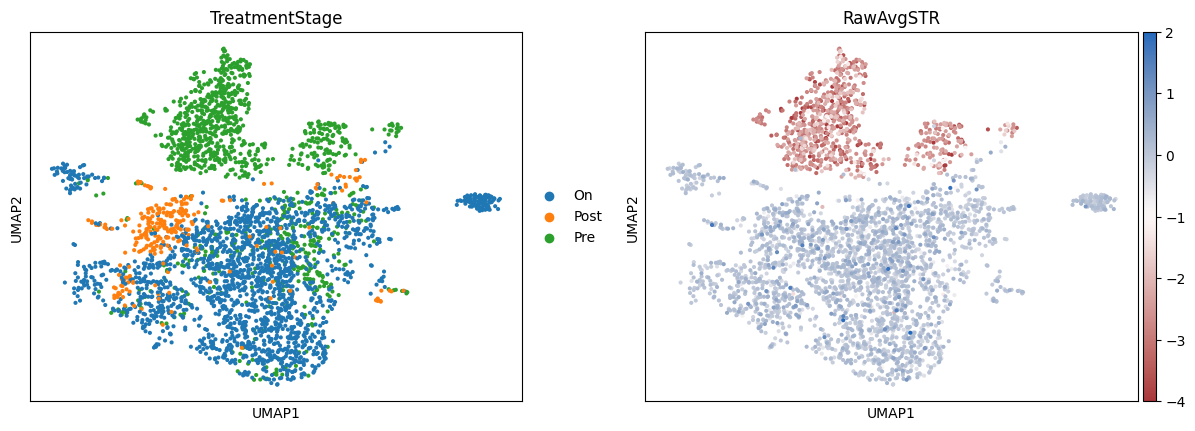

In [43]:
sc.pl.umap(adata_epi[adata_epi.obs['RawSTRn']>=10], color=['TreatmentStage', 'RawAvgSTR'], cmap='vlag_r', vmin=-4, vmax=2,)

<Axes: xlabel='RawAvgSTR', ylabel='SubCellType'>

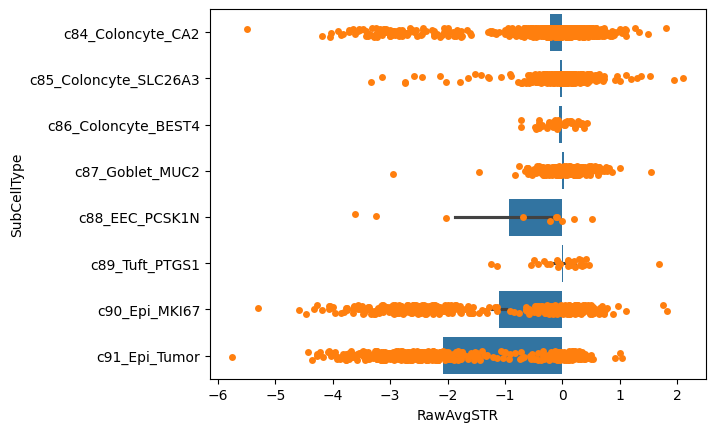

In [50]:
sns.barplot(data=adata_epi[adata_epi.obs['RawSTRn']>=10].obs, x='RawAvgSTR', y='SubCellType')
sns.stripplot(data=adata_epi[adata_epi.obs['RawSTRn']>=10].obs, x='RawAvgSTR', y='SubCellType')